In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import datetime as dt

pd.options.mode.chained_assignment = None  # default='warn'

In [331]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn import svm

#### 1. First clean: only take the useful columns

In [332]:
round3 = pd.read_json("round3_merged.json")
round2 = pd.read_json("round2_merged.json")
round1 = pd.read_json("round1_merged.json")

In [333]:
print round3.columns
print round2.columns
print round1.columns

Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'extra_people',
       u'guests_included', u'host_acceptance_rate', u'host_id',
       u'host_is_superhost', u'host_name', u'host_response_rate',
       u'host_response_time', u'host_total_listings_count', u'host_url', u'id',
       u'instant_bookable', u'listing_url', u'minimum_nights',
       u'monthly_price', u'nightly_plus_guest_price', u'nightly_price',
       u'nightly_price_scraped', u'number_of_reviews', u'openings',
       u'percent_agreed', u'price_agreed', u'price_requested', u'response',
       u'room_type'],
      dtype='object')
Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'host_acceptance_rate',
       u'host_id', u'host_is_superhost', u'ho

In [334]:
round3_clean = round3[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round2_clean = round2[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round1_clean = round1[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "availability", "price", "discount",
                       "calendars", "price_requested"]]

print "Number of observations in round 3: ", len(round3_clean)
print "Number of observations in round 2: ", len(round2_clean)
print "Number of observations in round 1: ", len(round1_clean)

# round3_clean.reset_index(drop=True).head()

Number of observations in round 3:  288
Number of observations in round 2:  226
Number of observations in round 1:  194


In [335]:
# round1_clean = round1_clean.rename(columns = {"price":"price_agreed", "discount":"percent_agreed"})

combined = pd.concat([round1_clean, round2_clean, round3_clean], keys=["round1", "round2", "round3"], ignore_index=False)
combined["source"] = combined.index.labels[0]+1
combined = combined.reset_index(drop=True)

In [336]:
combined.head()

,availability,bucket_name,calendars,decision,discount,discount_agreed,discount_asked,host_acceptance_rate,host_id,host_response_rate,host_total_listings_count,id,instant_bookable,nightly_price,percent_agreed,price,price_agreed,price_requested,room_type,source
0,0,daysM_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",NaN,None,NaN,0.7,100%,28811542,100%,1,5557381,t,51,NaN,NaN,NaN,35,Private room,1
1,-1,days1_weeksM,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",NaN,None,NaN,0.7,100%,403032,100%,1,9147025,f,134,NaN,NaN,NaN,90,Entire home/apt,1
2,-1,days3_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",NaN,None,NaN,0.9,100%,1172202,100%,5,2745620,t,41,NaN,NaN,NaN,35,Private room,1
3,-1,days2_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",NaN,None,NaN,0.7,92%,38964485,100%,2,7879486,f,101,NaN,NaN,NaN,70,Entire home/apt,1
4,0,daysM_weeks2,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",NaN,None,NaN,0.6,None,1594959,100%,1,3557570,f,65,NaN,NaN,NaN,35,Private room,1


#### 2. Add useful independent variables

Add variables from the calendars:
* median price
* standard deviation （normalized, using the median price)

In [268]:
calendar_price =  np.array([(np.median(calendar["price_USD"].values()), np.std(calendar["price_USD"].values()), np.max(calendar["price_USD"].values())) 
                            for calendar in round3_clean["calendars"].values])
calendar_median_price = calendar_price[:,0]
calendar_price_std = calendar_price[:,1]
calendar_price_high = calendar_price[:,2]

round3_clean["price_median"]=calendar_median_price
round3_clean["price_std"]=calendar_price_std/calendar_median_price
round3_clean["orig_percent_off"]=1-round3_clean["nightly_price"]/calendar_price_high

* 1-month occupancy rate

In [269]:
calendar_occupancy = [np.mean([calendar["availability"][key] for key in key_1m]) for calendar in round3_clean["calendars"].values]

round3_clean["occupancy_1m"]=calendar_occupancy

Convert string variables to numeric:
* whether room will be shared
* whether instant booking is turned on
* the response rate of the host (contains nans)

In [270]:
shared = round3_clean["room_type"].values
round3_clean["shared"] = [x!="Entire home/apt" for x in shared]
# shared_binary

instant = round3_clean["instant_bookable"].values
round3_clean["instant"] = [x=="t" for x in shared]
# instant_binary

In [271]:
response_imputer = Imputer(copy=True, missing_values='NaN', strategy='mean', axis=1)
response_num = np.array([float(response_rate.strip('%'))/100 for response_rate in round3_clean["host_response_rate"].fillna(value="-100%").values])
response_num = np.array([np.nan if x < 0 else x for x in response_num])
# response_imputer.fit(response_num)
response_imputed = response_imputer.fit_transform(response_num)[0]

# print len(response_imputed)
round3_clean["response_rate"] = response_imputed

/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


#### 3. Add indicators for the buckets

Construct 11 variables: 3 types of orphans, 2 types of advances, and 3x2=6 types of interactions

In [272]:
opening_attr = round3_clean["bucket_name"].values
# orphan = []
# advance = []
N = len(opening_attr)
orp_1 = np.zeros(N)
orp_2 = np.zeros(N)
orp_3 = np.zeros(N)
adv_1 = np.zeros(N)
adv_2 = np.zeros(N)

for (i,x) in enumerate(opening_attr):
    if x == "days1_weeks1":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days1_weeks2":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days1_weeksM":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days2_weeks1":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days2_weeks2":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days2_weeksM":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days3_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days3_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days3_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "daysM_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "daysM_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "daysM_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
        
round3_clean["orp_1"]=orp_1
round3_clean["orp_2"]=orp_2
round3_clean["orp_3"]=orp_3
round3_clean["adv_1"]=adv_1
round3_clean["adv_2"]=adv_2

In [273]:
round3_clean["orp_1, adv_1"] = round3_clean["orp_1"]*round3_clean["adv_1"]
round3_clean["orp_1, adv_2"] = round3_clean["orp_1"]*round3_clean["adv_2"]
round3_clean["orp_2, adv_1"] = round3_clean["orp_2"]*round3_clean["adv_1"]
round3_clean["orp_2, adv_2"] = round3_clean["orp_2"]*round3_clean["adv_2"]
round3_clean["orp_3, adv_1"] = round3_clean["orp_3"]*round3_clean["adv_1"]
round3_clean["orp_3, adv_2"] = round3_clean["orp_3"]*round3_clean["adv_2"]

In [274]:
round3_clean.columns

Index([                       u'id',                   u'host_id',
              u'host_response_rate',      u'host_acceptance_rate',
       u'host_total_listings_count',          u'instant_bookable',
                       u'room_type',               u'bucket_name',
                  u'discount_asked',             u'nightly_price',
                        u'decision',              u'price_agreed',
                 u'discount_agreed',            u'percent_agreed',
                       u'calendars',           u'price_requested',
                    u'price_median',                 u'price_std',
                u'orig_percent_off',              u'occupancy_1m',
                          u'shared',                   u'instant',
                   u'response_rate',                     u'orp_1',
                           u'orp_2',                     u'orp_3',
                           u'adv_1',                     u'adv_2',
                    u'orp_1, adv_1',              u'orp_1, adv

#### 4. Process the decision variables:

Calculate the percentage of the discount agreed:

In [275]:
round3_clean.groupby("decision")["id"].count()

decision
-1    144
 0     80
 1     64
Name: id, dtype: int64

In [276]:
orig_price = round3_clean["nightly_price"]
price_agreed_percent = (np.nan_to_num(round3_clean["price_agreed"])/orig_price)
discount_agreed1 = [0 if (d>=1 or d==0) else 1-d for d in price_agreed_percent]
discount_agreed2 = np.nan_to_num(round3_clean["discount_agreed"]/orig_price)
discount_agreed3 = np.nan_to_num(round3_clean["percent_agreed"])

discount_obtained = np.max([discount1, discount_agreed2, discount_agreed3], axis=0)
# print discount_agreed

round3_clean["discount_obtained"] = discount_agreed

### Again, only keep the useful columns

In [277]:
round3_clean.columns

Index([                       u'id',                   u'host_id',
              u'host_response_rate',      u'host_acceptance_rate',
       u'host_total_listings_count',          u'instant_bookable',
                       u'room_type',               u'bucket_name',
                  u'discount_asked',             u'nightly_price',
                        u'decision',              u'price_agreed',
                 u'discount_agreed',            u'percent_agreed',
                       u'calendars',           u'price_requested',
                    u'price_median',                 u'price_std',
                u'orig_percent_off',              u'occupancy_1m',
                          u'shared',                   u'instant',
                   u'response_rate',                     u'orp_1',
                           u'orp_2',                     u'orp_3',
                           u'adv_1',                     u'adv_2',
                    u'orp_1, adv_1',              u'orp_1, adv

In [278]:
round3_regress = round3_clean[["host_total_listings_count", "response_rate", "instant", "shared", 
                               "price_median", "price_std", "occupancy_1m",
                               "orp_1", "orp_2", "orp_3", "adv_1", "adv_2", 
                               "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
                               "orig_percent_off", "discount_asked", "decision", "discount_obtained"]]

In [279]:
round3_regress.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_1","orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained
0,5,0.890000,False,True,49,0.132639,0.100000,0,0,1,...,0,0,0,0,0,1,0.379747,0.9,0,0
1,5,1.000000,False,True,55,0.019470,0.600000,0,0,1,...,0,0,0,0,0,1,0.000000,0.7,0,0
10,1,0.910584,False,False,52,0.040914,0.533333,0,0,0,...,0,0,0,0,0,0,0.137931,0.9,0,0
100,2,1.000000,False,False,190,0.128456,0.033333,1,0,0,...,0,0,0,0,0,0,0.500000,0.6,0,0
101,2,1.000000,False,False,175,0.196970,0.200000,1,0,0,...,1,0,0,0,0,0,0.777778,0.6,0,0


### Construct training samples

In [280]:
round3_available = round3_regress[round3_regress["decision"]!=-1]
cal_param = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2", "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
all_param = cal_param + ["host_total_listings_count", "response_rate", "instant", "shared",  "price_median", "price_std", "occupancy_1m"]

X_train = round3_available[all_param].values
Y_train = round3_available["decision"].values

In [281]:
round3_available.isnull().sum()

host_total_listings_count    0
response_rate                0
instant                      0
shared                       0
price_median                 0
price_std                    0
occupancy_1m                 0
orp_1                        0
orp_2                        0
orp_3                        0
adv_1                        0
adv_2                        0
orp_1, adv_1                 0
orp_1, adv_2                 0
orp_2, adv_1                 0
orp_2, adv_2                 0
orp_3, adv_1                 0
orp_3, adv_2                 0
orig_percent_off             0
discount_asked               0
decision                     0
discount_obtained            0
dtype: int64

#### Logistic

In [282]:
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

lr_scores = -cross_val_score(logistic, X_train, Y_train, scoring='mean_squared_error', cv=10)

In [283]:
zip(all_param, np.ravel(logistic.coef_))

[('orp_1', -0.059035969950110227),
 ('orp_2', 0.34528542329210077),
 ('orp_3', 0.064086007519009155),
 ('adv_1', -0.08223985054410142),
 ('adv_2', 0.046105699144746028),
 ('orp_1, adv_1', -0.49652524058797903),
 ('orp_1, adv_2', 0.84921926845429174),
 ('orp_2, adv_1', 0.2592240657629723),
 ('orp_2, adv_2', 0.17764837994945465),
 ('orp_3, adv_1', -0.51284592179090305),
 ('orp_3, adv_2', 0.081611159242060499),
 ('host_total_listings_count', 0.10738962095861969),
 ('response_rate', -0.46272900306040138),
 ('instant', 0.0),
 ('shared', -0.3556813441408837),
 ('price_median', 0.0021273199467591601),
 ('price_std', -0.012283875579207999),
 ('occupancy_1m', -0.45875361081276017)]

In [284]:
print logistic.score(X_train, Y_train)
print lr_scores

0.652777777778
[ 0.6         0.53333333  0.4         0.46666667  0.42857143  0.42857143
  0.5         0.64285714  0.14285714  0.57142857]


#### Random Forest

In [285]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

rf_scores = -cross_val_score(rf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [286]:
print rf.score(X_train, Y_train)
print rf_scores

0.839861875
[ 0.26298276  0.30393103  0.26946897  0.35293448  0.28610714]


Feature ranking:
1. price_median (feature 15, importance: 0.185904)
2. occupancy_1m (feature 17, importance: 0.176558)
3. price_std (feature 16, importance: 0.168804)
4. response_rate (feature 12, importance: 0.136223)
5. host_total_listings_count (feature 11, importance: 0.102048)
6. shared (feature 14, importance: 0.040190)
7. adv_2 (feature 4, importance: 0.026955)
8. adv_1 (feature 3, importance: 0.025338)
9. orp_2 (feature 1, importance: 0.025320)
10. orp_1 (feature 0, importance: 0.018704)
11. orp_1, adv_2 (feature 6, importance: 0.018313)
12. orp_3 (feature 2, importance: 0.018081)
13. orp_2, adv_2 (feature 8, importance: 0.015674)
14. orp_2, adv_1 (feature 7, importance: 0.013345)
15. orp_3, adv_1 (feature 9, importance: 0.012477)
16. orp_3, adv_2 (feature 10, importance: 0.008718)
17. orp_1, adv_1 (feature 5, importance: 0.007349)
18. instant (feature 13, importance: 0.000000)


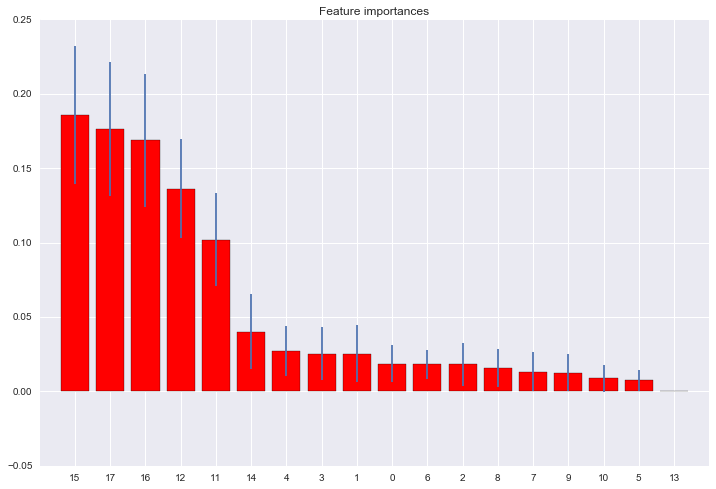

In [290]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# # Build a classification task using 3 informative features
# X_train, Y_train = make_classification(n_samples=1000,
#                            n_features=10,
#                            n_informative=3,
#                            n_redundant=0,
#                            n_repeated=0,
#                            n_classes=2,
#                            random_state=0,
#                            shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100,
                              random_state=0)

forest.fit(X_train, Y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (feature %d, importance: %f)" % (f + 1, all_param[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [108]:
available= pd.merge(responses[responses["availability"]!=-1], inside_airbnb, how='inner',left_on=['id'], right_on=['id'])

In [109]:
sample_count = available.groupby("bucket_name")["id"].count()
print len(available)
print sample_count

104
bucket_name
days1_weeks1    10
days1_weeksM     9
days2_weeks1     9
days2_weeks2    12
days2_weeksM    10
days3_weeks1    11
days3_weeks2     5
days3_weeksM     9
daysM_weeks1    10
daysM_weeks2     9
daysM_weeksM    10
Name: id, dtype: int64


In [110]:
cal_param = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2", "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
all_param = cal_param + ["discount_asked", "nightly_price", "shared", "instant"]

In [111]:
X_train = available[all_param].values
Y_train = available["availability"].values

## Logistic Regression

In [112]:
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

lr_scores = -cross_val_score(logistic, X_train, Y_train, scoring='mean_squared_error', cv=5)

#### Coefficient

In [113]:
zip(all_param, np.ravel(logistic.coef_))

[('orp_1', -0.67978310106545903),
 ('orp_2', 0.44899177569948689),
 ('orp_3', 0.48967858479423343),
 ('adv_1', -0.50649697324094611),
 ('adv_2', -0.45148027073001312),
 ('orp_1, adv_1', 0.2947336720609543),
 ('orp_1, adv_2', 0.0),
 ('orp_2, adv_1', -0.069988895069940132),
 ('orp_2, adv_2', 0.43221886011959287),
 ('orp_3, adv_1', -0.04378944953693914),
 ('orp_3, adv_2', 0.41504606143040967),
 ('discount_asked', -0.24696961430142622),
 ('nightly_price', 0.0044412580210620861),
 ('shared', 0.036177417352815128),
 ('instant', 0.0)]

#### Accuracy

In [114]:
logistic.score(X_train, Y_train)

0.69230769230769229

In [115]:
lr_scores

array([ 0.36363636,  0.72727273,  0.55      ,  0.4       ,  0.3       ])

#### Prediction

In [116]:
logistic.predict_proba(X_train)[:5]

array([[ 0.82316984,  0.17683016],
       [ 0.84021617,  0.15978383],
       [ 0.83849245,  0.16150755],
       [ 0.84180909,  0.15819091],
       [ 0.830444  ,  0.169556  ]])

## Random Forest

In [146]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

rf_scores = -cross_val_score(rf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [147]:
rf.score(X_train, Y_train)

0.84335812827753132

In [148]:
rf_scores

array([ 0.16735238,  0.23689048,  0.24374762,  0.26832857,  0.28012   ])

In [149]:
rf.predict(X_train)

array([ 0.07,  0.02,  0.  ,  0.16,  0.  ,  0.1 ,  0.74,  0.17,  0.75,
        0.06,  0.02,  0.69,  0.18,  0.05,  0.19,  0.13,  0.15,  0.17,
        0.08,  0.18,  0.04,  0.04,  0.07,  0.01,  0.68,  0.93,  0.11,
        0.93,  0.69,  0.12,  0.26,  0.68,  0.13,  0.31,  0.75,  0.19,
        0.94,  0.85,  0.76,  0.19,  0.13,  0.76,  0.97,  0.85,  0.21,
        0.05,  0.92,  0.92,  0.09,  0.04,  0.28,  0.03,  0.81,  0.08,
        0.05,  0.77,  0.75,  0.3 ,  0.67,  0.03,  0.08,  0.72,  0.8 ,
        0.83,  0.21,  0.19,  0.79,  0.09,  0.69,  0.21,  0.13,  0.26,
        0.74,  0.83,  0.66,  0.65,  0.09,  0.04,  0.09,  0.15,  0.04,
        0.35,  0.24,  0.03,  0.7 ,  0.16,  0.09,  0.68,  0.02,  0.08,
        0.1 ,  0.13,  0.13,  0.13,  0.24,  0.75,  0.68,  0.2 ,  0.06,
        0.74,  0.21,  0.71,  0.73,  0.09])

## SVM

In [134]:
clf = svm.SVC()
clf.fit(X_train, Y_train)  

clf_scores = -cross_val_score(clf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [135]:
clf.score(X_train, Y_train)

0.82692307692307687

In [136]:
clf_scores

array([ 0.45454545,  0.36363636,  0.4       ,  0.25      ,  0.35      ])

In [137]:
clf.support_vectors_

array([[   1.,    0.,    0., ...,   65.,    1.,    0.],
       [   1.,    0.,    0., ...,   32.,    1.,    0.],
       [   1.,    0.,    0., ...,   48.,    1.,    0.],
       ..., 
       [   0.,    0.,    0., ...,  283.,    0.,    0.],
       [   0.,    0.,    0., ...,   69.,    1.,    0.],
       [   0.,    0.,    0., ...,   72.,    1.,    0.]])